<img src="images/SDAIA.png" style="float: left; margin: 10px; height: 100px">
<img src="images/METIS.png" style="float: right; margin: 10px; height: 100px">

# MVP: Predicting Cardiovascular Disease with Classification Machine Learning Algorithms

### - Lama Ibrahim Alharbi

<img src="images/heart.jpg" style="float: margin: 10px; height: 350px">

In this project Notebook I will predict presence or absence of cardiovascular disease using the patient examination results by building classification machine learning models to classify the patients to be healthy or suffering from cardiovascular disease based on the given attributes.

In addition, the data found on `kaggle` [Cardiovascular Disease dataset](https://www.kaggle.com/sulianova/cardiovascular-disease-dataset). 

## 1 Libraries and Data Wrangling

In [348]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
from collections import Counter

# data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

#scores
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix

# To ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')

In [218]:
data = pd.read_csv('dataset/cardio.csv',delimiter=';')

In [174]:
data.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [4]:
data.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
print("The shape of the dataset is : ", data.shape)

The shape of the dataset is :  (70000, 13)


In [7]:
data.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

## 2 Data Description

There are 3 types of input features:
- Objective: factual information;
- Examination: results of medical examination;
- Subjective: information given by the patient.

<img src="images/dataset.png" style="float: left; margin: 10px; height: 400px">


## 3 Exploratory Data Analysis

The most important point in working with the data is to understand the it first, then try to find patterns in it by using the visualization because in the real-world, so it’s important to ask why this person particulary affected with `Cardiovascular Disease`?, to answer we need to look deeper to the features and the relationship.

In [8]:
quan_data = list(data.loc[:,data.dtypes != 'object'].columns.values)
quan_data.remove('cardio')

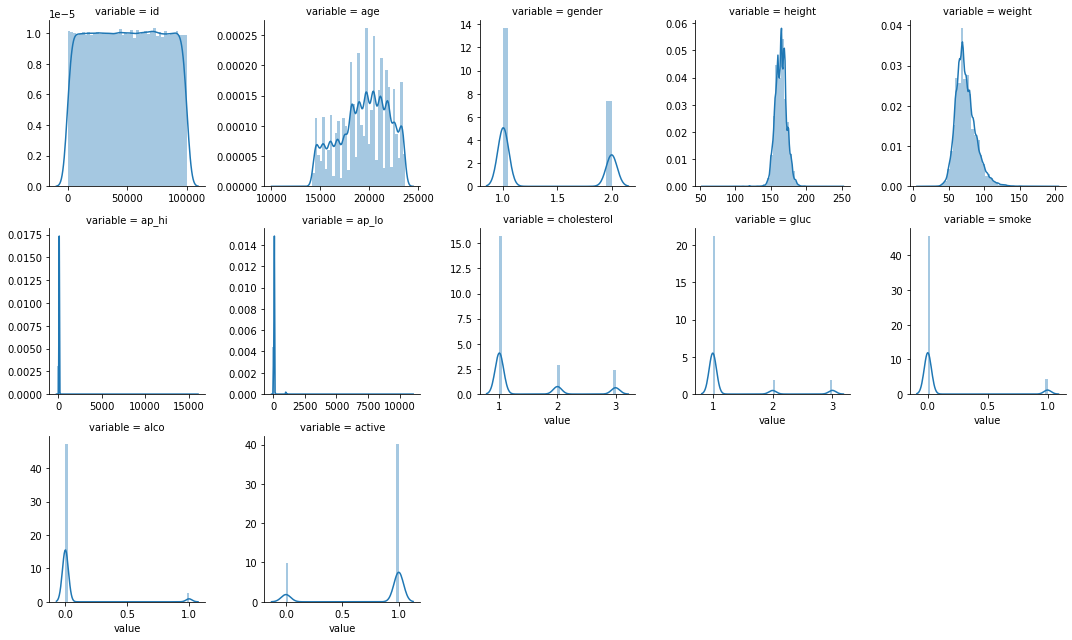

In [9]:
# visualize the distribution of each numerical feature

temp = pd.melt(data.drop('cardio',axis=1), value_vars= quan_data)
grid = sns.FacetGrid(temp, col="variable",  col_wrap=5 , size=3.0, 
                     aspect=1.0,sharex=False, sharey=False)
grid.map(sns.distplot, "value")
plt.show()

#### Observations
- For the `weight`, `cholestrol`,`gluc`, `smoke`, `alco` are positively skewed.
- The `age`, `active`, and `Embarked_S` are negatively skewed.

<AxesSubplot:>

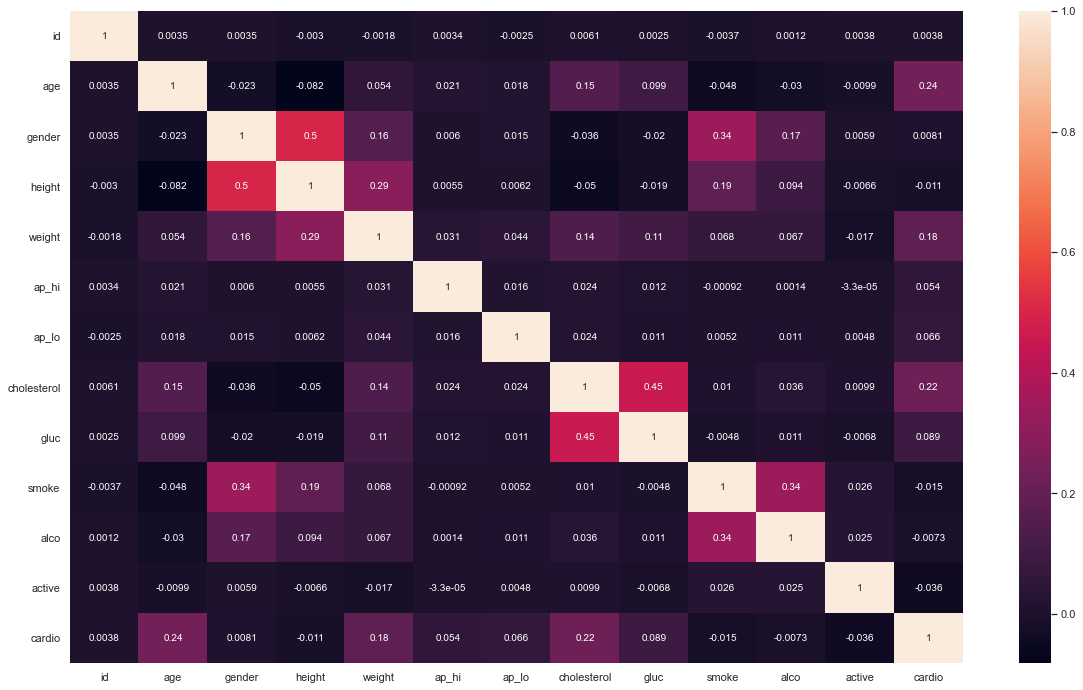

In [219]:
plt.figure(figsize=(20, 12))
sns.heatmap(data.corr(), annot=True)

#### List the features decendingly by correlation with cardio

In [220]:
cor_dict = corr['cardio'].to_dict()
del cor_dict['cardio']
print("List the features by their correlation with cardio:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: \t{1}".format(*ele))

List the features by their correlation with cardio:

ap_hi: 	0.42877718123307984
ap_lo: 	0.3170111586515193
cholesterol: 	0.22114727391225067
weight: 	0.1816595617986211
gluc: 	0.08930688732435302
active: 	-0.03565324811518795
smoke: 	-0.015485935661373308
height: 	-0.010821058331006026
gender: 	0.00810949191312318
alco: 	-0.007330231723206605


#### Observations
- The distribution of each variable with itself is shown on the diagonal
- To see patterns the observable pattern is that all the variables correlate with each other. On the bottom of the diagonal : we can see the negative correlations.
- On the top of the diagonal : the positive correlation is displayed.

### 3.1 Uni-variate Analysis

#### 1. cardio Feature

<AxesSubplot:xlabel='cardio', ylabel='count'>

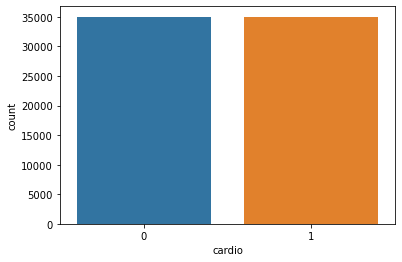

In [13]:
# Countplot counts the each category of value and plot that.
sns.countplot(data['cardio'],data = data)

- This is the target we want to predict and from the graph it shows that the data is balanced 

#### 2. cholesterol Feature

<AxesSubplot:xlabel='cholesterol', ylabel='count'>

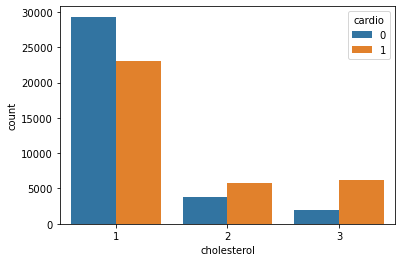

In [14]:
sns.countplot(data["cholesterol"],hue = data["cardio"],data = data)


- The `cholesterol` majority is `1` which means `normal`

#### 3. Glucose Feature

<AxesSubplot:xlabel='gluc', ylabel='count'>

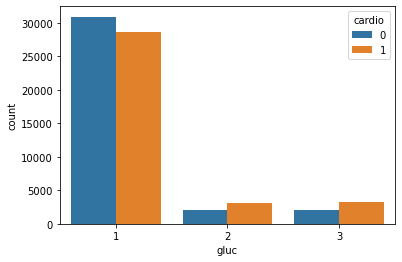

In [15]:
sns.countplot(data["gluc"],hue = data["cardio"],data = data)


- The `Glucose` majority is `1` which means `normal`

#### 4. smoke Feature

<AxesSubplot:xlabel='smoke', ylabel='count'>

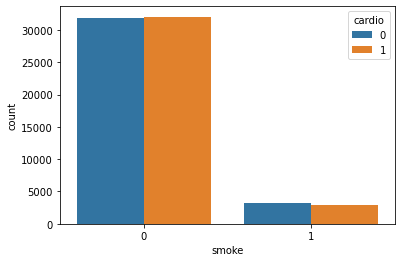

In [16]:
sns.countplot(data["smoke"],hue = data["cardio"],data = data)


- The majority of patients are `not smoking`

#### 5. Alcohol Feature

<AxesSubplot:xlabel='alco', ylabel='count'>

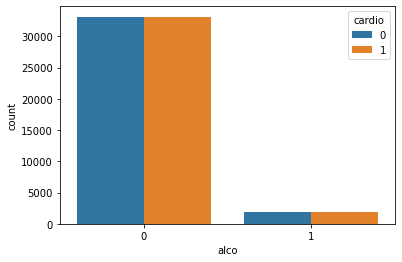

In [17]:
sns.countplot(data["alco"],hue = data["cardio"],data = data)


- The majority of patients are `not drinking`

#### 6. Active Feature

<AxesSubplot:xlabel='active', ylabel='count'>

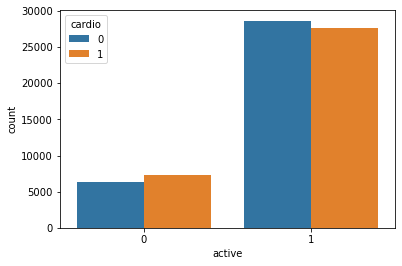

In [18]:
sns.countplot(data["active"],hue = data["cardio"],data = data)


- The majority of patients are `Active`

In [24]:
pp.ProfileReport(data)

## 4 Data Cleaning

In [25]:
data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [26]:
data.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

- The data has no null values so there is no need to do more cleaning. Also the types of data is correct.
- But for the `age` column we might need to convert it from age to years.

#### Convert age from days to years

In [221]:
#before
data.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [222]:
def convert_age(days):
    years = days // 365
    return years

data['age']=data['age'].apply(convert_age)

In [223]:
#after
data.head()

id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0   50       2     168    62.0    110     80            1     1      0   
1   1   55       1     156    85.0    140     90            3     1      0   
2   2   51       1     165    64.0    130     70            3     1      0   
3   3   48       2     169    82.0    150    100            1     1      0   
4   4   47       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [224]:
# drop id column
data = data.drop('id', axis=1)

- now lets check if we have Unbeleiveble Values
- By studying each column reasonable values

#### Understanding Blood pressure feature `ap_hi`, `ap_lo`

<img src="images/blood.jpg" style="float: margin: 10px; height: 350px">

In [225]:
data[(data['ap_hi'] > 180 ) | (data['ap_lo'] > 120)]

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
101     51       1     167    80.0    190     90            2     1      0   
228     47       2     183    98.0    160   1100            1     2      1   
241     60       2     157    60.0    160   1000            2     1      0   
260     49       1     150    83.0    140    800            1     1      0   
329     64       1     176    63.0    160   1000            2     2      0   
...    ...     ...     ...     ...    ...    ...          ...   ...    ...   
69872   59       1     152    56.0    160   1000            1     1      0   
69878   58       2     168    95.0    160   1000            1     1      0   
69885   61       2     166    78.0    170   1000            1     1      0   
69894   46       1     160    70.0    200    100            1     2      0   
69967   58       2     168    63.0    140   1000            1     1      0   

       alco  active  cardio  
101       1       0       0  
228       0       1       1  
241       0       0       1  
260       0       1       1  
329       0       0       1  
...     ...     ...     ...  
69872     0       1       1  
69878     0       1       1  
69885     0       0       0  
69894     0       1       1  
69967     0       1       1  

[1348 rows x 12 columns]

- ap_lo Column it Does Not Have True Value's becauce 1000 or 800

In [226]:
data['ap_lo'].describe()

count    70000.000000
mean        96.630414
std        188.472530
min        -70.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

In [227]:
data['ap_hi'].describe()

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

- Because We Have Age More Than 30 The ap_lo Values Must Above 76 And ap_hi be 108

In [228]:
data['ap_lo']  = data['ap_lo'].apply(lambda x: (np.nan if x <= 76 else x))
data['ap_lo']  = data['ap_lo'].apply(lambda x: (np.nan if x >= 130 else x))

In [229]:
data['ap_lo'].describe()

count    55236.000000
mean        84.612753
std          7.044756
min         77.000000
25%         80.000000
50%         80.000000
75%         90.000000
max        126.000000
Name: ap_lo, dtype: float64

In [230]:
data['ap_hi']  = data['ap_hi'].apply(lambda x: (np.nan if x <= 108 else x))
data['ap_hi']  = data['ap_hi'].apply(lambda x: (np.nan if x >= 200 else x))

In [231]:
data['ap_hi'].describe()

count    65739.000000
mean       128.568536
std         15.354328
min        109.000000
25%        120.000000
50%        120.000000
75%        140.000000
max        199.000000
Name: ap_hi, dtype: float64

In [232]:
data['gender'].unique()

array([2, 1])

In [233]:
data['weight'].describe()

count    70000.000000
mean        74.205690
std         14.395757
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

In [234]:
print('1 - women Kg')
print(data[data['gender'] == 1]['weight'].describe())
print('----------------------------------------------------------------------------------------')
print('2 - men Kg')
print(data[data['gender'] == 2]['weight'].describe())

1 - women Kg
count    45530.000000
mean        72.565605
std         14.238838
min         21.000000
25%         63.000000
50%         70.000000
75%         80.000000
max        200.000000
Name: weight, dtype: float64
----------------------------------------------------------------------------------------
2 - men Kg
count    24470.000000
mean        77.257307
std         14.187636
min         10.000000
25%         68.000000
50%         75.000000
75%         85.000000
max        200.000000
Name: weight, dtype: float64


In [235]:
print('1 - women CM')
print(data[data['gender'] == 1]['height'].describe())
print('----------------------------------------------------------------------------------------')
print('2 - men CM')
print(data[data['gender'] == 2]['height'].describe())

1 - women CM
count    45530.000000
mean       161.355612
std          7.052726
min         55.000000
25%        157.000000
50%        161.000000
75%        166.000000
max        250.000000
Name: height, dtype: float64
----------------------------------------------------------------------------------------
2 - men CM
count    24470.000000
mean       169.947895
std          7.228895
min         65.000000
25%        165.000000
50%        170.000000
75%        175.000000
max        207.000000
Name: height, dtype: float64


- Now We Have Null value

- We Can Use mean or KNN for Null value

- In This case We use imputer KNN

In [244]:
data['cholesterol'].value_counts()
#1: normal, 2: above normal, 3: well above normal |

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

In [245]:
data['gluc'].value_counts()
# 1: normal, 2: above normal, 3: well above normal

1    59479
3     5331
2     5190
Name: gluc, dtype: int64

In [246]:
data['gender'].value_counts()
# 1 - women, 2 - men

1    45530
2    24470
Name: gender, dtype: int64

In [247]:
imputer = KNNImputer(sn_neighbors=3)
impute = imputer.fit_transform(data)
impue = pd.DataFrame(impute, columns=data.columns)
impute.head()

age  gender  height  weight  ap_hi       ap_lo  cholesterol  gluc  smoke  \
0  50.0     2.0   168.0    62.0  110.0   80.000000          1.0   1.0    0.0   
1  55.0     1.0   156.0    85.0  140.0   90.000000          3.0   1.0    0.0   
2  51.0     1.0   165.0    64.0  130.0   83.333333          3.0   1.0    0.0   
3  48.0     2.0   169.0    82.0  150.0  100.000000          1.0   1.0    0.0   
4  47.0     1.0   156.0    56.0  120.0   80.000000          1.0   1.0    0.0   

   alco  active  cardio  
0   0.0     1.0     0.0  
1   0.0     1.0     1.0  
2   0.0     0.0     1.0  
3   0.0     1.0     1.0  
4   0.0     0.0     0.0

In [291]:
impute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  float64
 2   height       70000 non-null  float64
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  float64
 5   ap_lo        70000 non-null  float64
 6   cholesterol  70000 non-null  float64
 7   gluc         70000 non-null  float64
 8   smoke        70000 non-null  float64
 9   alco         70000 non-null  float64
 10  active       70000 non-null  float64
 11  cardio       70000 non-null  float64
dtypes: float64(12)
memory usage: 6.4 MB


<AxesSubplot:>

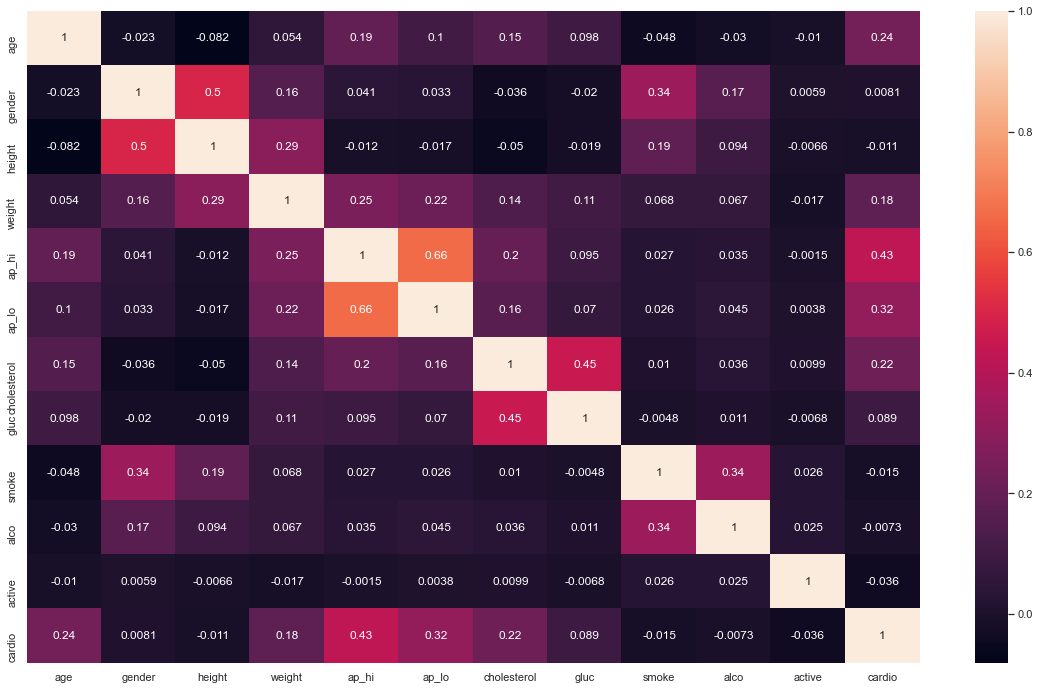

In [248]:
plt.figure(figsize=(20, 12))
sns.heatmap(impute.corr(), annot=True)

In [252]:
transform = ColumnTransformer(transformers=[('cat', MinMaxScaler(), [0, 2, 3, 4, 5])] ,remainder='passthrough', n_jobs=-1)
tr = transform.fit_transform(impute)

In [253]:
tr = pd.DataFrame(tr, columns=data.columns)
tr.head()

age    gender    height    weight     ap_hi  ap_lo  cholesterol  gluc  \
0  0.600000  0.579487  0.273684  0.011111  0.061224    2.0          1.0   1.0   
1  0.742857  0.517949  0.394737  0.344444  0.265306    1.0          3.0   1.0   
2  0.628571  0.564103  0.284211  0.233333  0.129252    1.0          3.0   1.0   
3  0.542857  0.584615  0.378947  0.455556  0.469388    2.0          1.0   1.0   
4  0.514286  0.517949  0.242105  0.122222  0.061224    1.0          1.0   1.0   

   smoke  alco  active  cardio  
0    0.0   0.0     1.0     0.0  
1    0.0   0.0     1.0     1.0  
2    0.0   0.0     0.0     1.0  
3    0.0   0.0     1.0     1.0  
4    0.0   0.0     0.0     0.0

In [254]:
tr.iloc[:, 5:11] = tr.iloc[:, 5:11].astype('object')
dummies = pd.get_dummies(tr)

In [255]:
dummies

age    gender    height    weight     ap_hi  cardio  ap_lo_1.0  \
0      0.600000  0.579487  0.273684  0.011111  0.061224     0.0          0   
1      0.742857  0.517949  0.394737  0.344444  0.265306     1.0          1   
2      0.628571  0.564103  0.284211  0.233333  0.129252     1.0          1   
3      0.542857  0.584615  0.378947  0.455556  0.469388     1.0          0   
4      0.514286  0.517949  0.242105  0.122222  0.061224     0.0          1   
...         ...       ...       ...       ...       ...     ...        ...   
69995  0.657143  0.579487  0.347368  0.122222  0.061224     0.0          0   
69996  0.914286  0.528205  0.610526  0.344444  0.265306     1.0          1   
69997  0.657143  0.656410  0.500000  0.788889  0.265306     1.0          0   
69998  0.914286  0.553846  0.326316  0.288889  0.061224     1.0          1   
69999  0.771429  0.589744  0.326316  0.122222  0.061224     0.0          1   

       ap_lo_2.0  cholesterol_1.0  cholesterol_2.0  cholesterol_3.0  gluc_1.0  \
0              1                1                0                0         1   
1              0                0                0                1         1   
2              0                0                0                1         1   
3              1                1                0                0         1   
4              0                1                0                0         1   
...          ...              ...              ...              ...       ...   
69995          1                1                0                0         1   
69996          0                0                1                0         0   
69997          1                0                0                1         1   
69998          0                1                0                0         0   
69999          0                0                1                0         1   

       gluc_2.0  gluc_3.0  smoke_0.0  smoke_1.0  alco_0.0  alco_1.0  \
0             0         0          1          0         1         0   
1             0         0          1          0         1         0   
2             0         0          1          0         1         0   
3             0         0          1          0         1         0   
4             0         0          1          0         1         0   
...         ...       ...        ...        ...       ...       ...   
69995         0         0          0          1         1         0   
69996         1         0          1          0         1         0   
69997         0         0          1          0         0         1   
69998         1         0          1          0         1         0   
69999         0         0          1          0         1         0   

       active_0.0  active_1.0  
0               0           1  
1               0           1  
2               1           0  
3               0           1  
4               1           0  
...           ...         ...  
69995           0           1  
69996           0           1  
69997           1           0  
69998           1           0  
69999           0           1  

[70000 rows x 20 columns]

In [292]:
dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              70000 non-null  float64
 1   gender           70000 non-null  float64
 2   height           70000 non-null  float64
 3   weight           70000 non-null  float64
 4   ap_hi            70000 non-null  float64
 5   cardio           70000 non-null  float64
 6   ap_lo_1.0        70000 non-null  uint8  
 7   ap_lo_2.0        70000 non-null  uint8  
 8   cholesterol_1.0  70000 non-null  uint8  
 9   cholesterol_2.0  70000 non-null  uint8  
 10  cholesterol_3.0  70000 non-null  uint8  
 11  gluc_1.0         70000 non-null  uint8  
 12  gluc_2.0         70000 non-null  uint8  
 13  gluc_3.0         70000 non-null  uint8  
 14  smoke_0.0        70000 non-null  uint8  
 15  smoke_1.0        70000 non-null  uint8  
 16  alco_0.0         70000 non-null  uint8  
 17  alco_1.0    

## 5 Modeling

### 5.1 Model prepration

In [6]:
y = data["cardio"]
X = data.drop('cardio',axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
X_train, X_test, y_train, y_test =train_test_split(x3, y, test_size=0.3, random_state=1)

In [259]:
y = dummies["cardio"]
X = dummies.drop('cardio',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

Before applying algorithm we should check whether the data is equally splitted or not, because if data is not splitted equally it will cause for data imbalacing problem

In [257]:
print(y_test.unique())
Counter(y_train)

[0. 1.]


Counter({1.0: 28048, 0.0: 27952})

In [258]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 5.2 ML models

- Train different machine learning algorithm and try to find the model that predict accurately.

#### - Decision Tree

In [299]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree_predicted = dtree.predict(X_test)
dtree_conf_matrix = confusion_matrix(y_test, dtree_predicted)
dtree_acc_score = accuracy_score(y_test, dtree_predicted)
print("confussion matrix")
print(dtree_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dtree_acc_score*100,'\n')
print(classification_report(y_test,dtree_predicted))
dtree_val = cross_val_score(dtree, X_train, y_train, cv=5)
print("Cross Validation Accuracy of DecisionTreeClassifier:",dtree_val.mean()*100,'\n')

confussion matrix
[[4599 2470]
 [2752 4179]]


Accuracy of DecisionTreeClassifier: 62.7 

              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64      7069
         1.0       0.63      0.60      0.62      6931

    accuracy                           0.63     14000
   macro avg       0.63      0.63      0.63     14000
weighted avg       0.63      0.63      0.63     14000

Cross Validation Accuracy of DecisionTreeClassifier: 63.82678571428572 



In [300]:
dtree = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dtree.fit(X_train, y_train)
dtree_predicted = dtree.predict(X_test)
dtree_conf_matrix = confusion_matrix(y_test, dtree_predicted)
dtree_acc_score = accuracy_score(y_test, dtree_predicted)
print("confussion matrix")
print(dtree_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dtree_acc_score*100,'\n')
print(classification_report(y_test,dtree_predicted))
dtree_val = cross_val_score(dtree, X_train, y_train, cv=5)
print("Cross Validation Accuracy of DecisionTreeClassifier:",dtree_val.mean()*100,'\n')

confussion matrix
[[5675 1394]
 [2389 4542]]


Accuracy of DecisionTreeClassifier: 72.97857142857143 

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75      7069
         1.0       0.77      0.66      0.71      6931

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000

Cross Validation Accuracy of DecisionTreeClassifier: 73.25535714285714 



#### - Random Forest 

In [301]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))
rf_val = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross Validation Accuracy of RandomForestClassifier:",rf_val.mean()*100,'\n')

confussion matrix
[[4944 2125]
 [2092 4839]]


Accuracy of Random Forest: 69.87857142857142 

              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70      7069
         1.0       0.69      0.70      0.70      6931

    accuracy                           0.70     14000
   macro avg       0.70      0.70      0.70     14000
weighted avg       0.70      0.70      0.70     14000

Cross Validation Accuracy of RandomForestClassifier: 70.43035714285713 



In [302]:
rf = RandomForestClassifier(n_estimators=100, max_features=12, max_depth=5, random_state=0)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))
rf_val = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross Validation Accuracy of RandomForestClassifier:",rf_val.mean()*100,'\n')

confussion matrix
[[5600 1469]
 [2276 4655]]


Accuracy of Random Forest: 73.25 

              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75      7069
         1.0       0.76      0.67      0.71      6931

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.73     14000
weighted avg       0.74      0.73      0.73     14000

Cross Validation Accuracy of RandomForestClassifier: 73.26607142857142 



#### - Logistic Regression

In [309]:
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))
lr_val = cross_val_score(lr, X_train, y_train, cv=5)
print("Cross Validation Accuracy of LogisticRegression:",lr_val.mean()*100,'\n')

confussion matrix
[[5605 1464]
 [2393 4538]]


Accuracy of Logistic Regression: 72.45 

              precision    recall  f1-score   support

         0.0       0.70      0.79      0.74      7069
         1.0       0.76      0.65      0.70      6931

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

Cross Validation Accuracy of LogisticRegression: 72.90357142857144 



In [308]:
lr = LogisticRegression(C=6, random_state=0)
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))
lr_val = cross_val_score(lr, X_train, y_train, cv=5)
print("Cross Validation Accuracy of LogisticRegression:",lr_val.mean()*100,'\n')

confussion matrix
[[5603 1466]
 [2393 4538]]


Accuracy of Logistic Regression: 72.43571428571428 

              precision    recall  f1-score   support

         0.0       0.70      0.79      0.74      7069
         1.0       0.76      0.65      0.70      6931

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

Cross Validation Accuracy of LogisticRegression: 72.90535714285714 



#### - Naive Bayes

In [307]:
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))
nb_val = cross_val_score(nb, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Naive Bayes:",nb_val.mean()*100,'\n')

confussion matrix
[[5564 1505]
 [3035 3896]]


Accuracy of Naive Bayes model: 67.57142857142857 

              precision    recall  f1-score   support

         0.0       0.65      0.79      0.71      7069
         1.0       0.72      0.56      0.63      6931

    accuracy                           0.68     14000
   macro avg       0.68      0.67      0.67     14000
weighted avg       0.68      0.68      0.67     14000

Cross Validation Accuracy of Naive Bayes: 68.03928571428571 



#### - Linear SVC

In [310]:
lnsvc = LinearSVC(random_state=0)
lnsvc.fit(X_train,y_train)
nbpred = lnsvc.predict(X_test)
lnsvc_conf_matrix = confusion_matrix(y_test, nbpred)
lnsvc_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(lnsvc_conf_matrix)
print("\n")
print("Accuracy of Linear SVC model:",lnsvc_acc_score*100,'\n')
print(classification_report(y_test,nbpred))
lnsvc_val = cross_val_score(lnsvc, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Linear SVC:",lnsvc_val.mean()*100,'\n')

confussion matrix
[[5685 1384]
 [2483 4448]]


Accuracy of Linear SVC model: 72.37857142857142 

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75      7069
         1.0       0.76      0.64      0.70      6931

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

Cross Validation Accuracy of Linear SVC: 72.81785714285715 



#### - XG Boost

In [311]:
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))
xgb_val = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Extreme Gradient Boost:",xgb_val.mean()*100,'\n')

confussion matrix
[[5577 1492]
 [2304 4627]]


Accuracy of Extreme Gradient Boost: 72.88571428571429 

              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75      7069
         1.0       0.76      0.67      0.71      6931

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000

Cross Validation Accuracy of Extreme Gradient Boost: 73.38928571428572 



#### - K-Nearest Neighbour

In [312]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))
knn_val = cross_val_score(knn, X_train, y_train, cv=5)
print("Cross Validation Accuracy of K-NeighborsClassifier:",knn_val.mean()*100,'\n')

confussion matrix
[[5435 1634]
 [2453 4478]]


Accuracy of K-NeighborsClassifier: 70.80714285714286 

              precision    recall  f1-score   support

         0.0       0.69      0.77      0.73      7069
         1.0       0.73      0.65      0.69      6931

    accuracy                           0.71     14000
   macro avg       0.71      0.71      0.71     14000
weighted avg       0.71      0.71      0.71     14000

Cross Validation Accuracy of K-NeighborsClassifier: 71.55892857142857 



#### - Support Vector Machine

In [313]:
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))
svc_val = cross_val_score(svc, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Support Vector Classifier:",svc_val.mean()*100,'\n')

confussion matrix
[[5592 1477]
 [2350 4581]]


Accuracy of Support Vector Classifier: 72.66428571428571 

              precision    recall  f1-score   support

         0.0       0.70      0.79      0.75      7069
         1.0       0.76      0.66      0.71      6931

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000

Cross Validation Accuracy of Support Vector Classifier: 72.89642857142857 



#### - Extra Tree Classifier

In [314]:
par = {'bootstrap': [True],
 'max_depth': [12],
 'min_samples_leaf': [4],
 'min_samples_split': [3],
 'n_estimators': [8]}
ex = GridSearchCV(ExtraTreesClassifier(),
                   par , cv = 5 , verbose= 1  , n_jobs= -1)
ex.fit(X_train , y_train)
ex_predicted = ex.predict(X_test)
ex_conf_matrix = confusion_matrix(y_test, ex_predicted)
ex_acc_score = accuracy_score(y_test, ex_predicted)
print("confussion matrix")
print(ex_conf_matrix)
print("\n")
print("Accuracy of Extra Tree Classifier:",ex_acc_score*100,'\n')
print(classification_report(y_test,ex_predicted))
ex_val = cross_val_score(ex, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Extra Tree Classifier:",ex_val.mean()*100,'\n')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.0s finished


confussion matrix
[[5624 1445]
 [2361 4570]]


Accuracy of Extra Tree Classifier: 72.8142857142857 

              precision    recall  f1-score   support

         0.0       0.70      0.80      0.75      7069
         1.0       0.76      0.66      0.71      6931

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Cross Validation Accuracy of Extra Tree Classifier: 72.60535714285714 



#### - GradientBoostingClassifier

In [315]:
gradient = GradientBoostingClassifier(random_state=0, learning_rate=0.15)
gradient.fit(X_train , y_train)
gradient_predicted = gradient.predict(X_test)
gradient_conf_matrix = confusion_matrix(y_test, gradient_predicted)
gradient_acc_score = accuracy_score(y_test, gradient_predicted)
print("confussion matrix")
print(gradient_conf_matrix)
print("\n")
print("Accuracy of GradientBoostingClassifier:",gradient_acc_score*100,'\n')
print(classification_report(y_test,gradient_predicted))
gradient_val = cross_val_score(gradient, X_train, y_train, cv=5)
print("Cross Validation Accuracy of GradientBoostingClassifier:",gradient_val.mean()*100,'\n')

confussion matrix
[[5489 1580]
 [2136 4795]]


Accuracy of GradientBoostingClassifier: 73.45714285714286 

              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75      7069
         1.0       0.75      0.69      0.72      6931

    accuracy                           0.73     14000
   macro avg       0.74      0.73      0.73     14000
weighted avg       0.74      0.73      0.73     14000

Cross Validation Accuracy of GradientBoostingClassifier: 73.66071428571429 



#### - AdaBoostClassifier

In [316]:
AdaBoost = AdaBoostClassifier(random_state=0, learning_rate=0.15)
AdaBoost.fit(X_train , y_train)
AdaBoost_predicted = AdaBoost.predict(X_test)
AdaBoost_conf_matrix = confusion_matrix(y_test, AdaBoost_predicted)
AdaBoost_acc_score = accuracy_score(y_test, AdaBoost_predicted)
print("confussion matrix")
print(AdaBoost_conf_matrix)
print("\n")
print("Accuracy of AdaBoostClassifier:",AdaBoost_acc_score*100,'\n')
print(classification_report(y_test,AdaBoost_predicted))
AdaBoost_val = cross_val_score(AdaBoost, X_train, y_train, cv=5)
print("Cross Validation Accuracy of AdaBoostClassifier:",AdaBoost_val.mean()*100,'\n')

confussion matrix
[[5726 1343]
 [2535 4396]]


Accuracy of AdaBoostClassifier: 72.3 

              precision    recall  f1-score   support

         0.0       0.69      0.81      0.75      7069
         1.0       0.77      0.63      0.69      6931

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

Cross Validation Accuracy of AdaBoostClassifier: 72.43214285714285 



#### - Perceptron

In [318]:
perceptron = Perceptron()
perceptron.fit(X_train , y_train)
perceptron_predicted = perceptron.predict(X_test)
perceptron_conf_matrix = confusion_matrix(y_test, perceptron_predicted)
perceptron_acc_score = accuracy_score(y_test, perceptron_predicted)
print("confussion matrix")
print(perceptron_conf_matrix)
print("\n")
print("Accuracy of Perceptron Classifier:",perceptron_acc_score*100,'\n')
print(classification_report(y_test,perceptron_predicted))
perceptron_val = cross_val_score(perceptron, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Perceptron Classifier:",perceptron_val.mean()*100,'\n')

confussion matrix
[[6322  747]
 [4038 2893]]


Accuracy of Perceptron Classifier: 65.82142857142857 

              precision    recall  f1-score   support

         0.0       0.61      0.89      0.73      7069
         1.0       0.79      0.42      0.55      6931

    accuracy                           0.66     14000
   macro avg       0.70      0.66      0.64     14000
weighted avg       0.70      0.66      0.64     14000

Cross Validation Accuracy of Perceptron Classifier: 60.11071428571428 



#### - Stochastic Gradient Descent

In [319]:
sgd = SGDClassifier()
sgd.fit(X_train , y_train)
sgd_predicted = sgd.predict(X_test)
sgd_conf_matrix = confusion_matrix(y_test, sgd_predicted)
sgd_acc_score = accuracy_score(y_test, sgd_predicted)
print("confussion matrix")
print(sgd_conf_matrix)
print("\n")
print("Accuracy of Stochastic Gradient Descent Classifier:",sgd_acc_score*100,'\n')
print(classification_report(y_test,sgd_predicted))
sgd_val = cross_val_score(sgd, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Stochastic Gradient Descent Classifier:",sgd_val.mean()*100,'\n')

confussion matrix
[[5904 1165]
 [2731 4200]]


Accuracy of Stochastic Gradient Descent Classifier: 72.17142857142858 

              precision    recall  f1-score   support

         0.0       0.68      0.84      0.75      7069
         1.0       0.78      0.61      0.68      6931

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

Cross Validation Accuracy of Stochastic Gradient Descent Classifier: 72.61428571428571 



#### - RidgeClassifier

In [320]:
ridge = RidgeClassifier()
ridge.fit(X_train , y_train)
ridge_predicted = ridge.predict(X_test)
ridge_conf_matrix = confusion_matrix(y_test, ridge_predicted)
ridge_acc_score = accuracy_score(y_test, ridge_predicted)
print("confussion matrix")
print(ridge_conf_matrix)
print("\n")
print("Accuracy of Ridge Classifier:",ridge_acc_score*100,'\n')
print(classification_report(y_test,ridge_predicted))
ridge_val = cross_val_score(ridge, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Ridge Classifier:",ridge_val.mean()*100,'\n')

confussion matrix
[[5704 1365]
 [2542 4389]]


Accuracy of Ridge Classifier: 72.09285714285714 

              precision    recall  f1-score   support

         0.0       0.69      0.81      0.74      7069
         1.0       0.76      0.63      0.69      6931

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000

Cross Validation Accuracy of Ridge Classifier: 72.64821428571429 



#### - BaggingClassifier

In [321]:
bagging = BaggingClassifier()
bagging.fit(X_train , y_train)
bagging_predicted = bagging.predict(X_test)
bagging_conf_matrix = confusion_matrix(y_test, bagging_predicted)
bagging_acc_score = accuracy_score(y_test, bagging_predicted)
print("confussion matrix")
print(bagging_conf_matrix)
print("\n")
print("Accuracy of Bagging Classifier:",bagging_acc_score*100,'\n')
print(classification_report(y_test,bagging_predicted))
bagging_val = cross_val_score(bagging, X_train, y_train, cv=5)
print("Cross Validation Accuracy of Bagging Classifier:",bagging_val.mean()*100,'\n')

confussion matrix
[[5058 2011]
 [2447 4484]]


Accuracy of Bagging Classifier: 68.15714285714286 

              precision    recall  f1-score   support

         0.0       0.67      0.72      0.69      7069
         1.0       0.69      0.65      0.67      6931

    accuracy                           0.68     14000
   macro avg       0.68      0.68      0.68     14000
weighted avg       0.68      0.68      0.68     14000

Cross Validation Accuracy of Bagging Classifier: 68.40714285714287 



## 6 Comparing Results

In [326]:
models = pd.DataFrame({
    'Model': ['DecisionTreeClassifier', 'RandomForestClassifier','LogisticRegression', 'NaiveBayes',
              'XGBoost', 'LinearSVC','K-NeighborsClassifier', 'SupportVectorClassifier', 'ExtraTreeClassifier','GradientBoostingClassifier'
             ,'AdaBoostClassifier','perceptron',"SGDClassifier",'RidgeClassifier','BaggingClassifier'],
    'Score': [dtree_acc_score*100, rf_acc_score*100, lr_acc_score*100, nb_acc_score*100,lnsvc_acc_score*100,
              xgb_acc_score*100, knn_acc_score*100,svc_acc_score*100, ex_acc_score*100,gradient_acc_score*100,
              AdaBoost_acc_score*100,perceptron_acc_score*100,sgd_acc_score*100,ridge_acc_score*100,bagging_acc_score*100],
    'val accuracy': [dtree_val.mean()*100, rf_val.mean()*100, lr_val.mean()*100, nb_val.mean()*100,
                     lnsvc_val.mean()*100, xgb_val.mean()*100, knn_val.mean()*100, svc_val.mean()*100,
                     ex_val.mean()*100,gradient_val.mean()*100,AdaBoost_val.mean()*100,perceptron_val.mean()*100,
                     sgd_val.mean()*100,ridge_val.mean()*100,bagging_val.mean()*100]})
models.sort_values(by='Score', ascending=False)

Model      Score  val accuracy
9   GradientBoostingClassifier  73.457143     73.660714
1       RandomForestClassifier  73.250000     73.266071
0       DecisionTreeClassifier  72.978571     73.255357
5                    LinearSVC  72.885714     73.389286
8          ExtraTreeClassifier  72.814286     72.605357
7      SupportVectorClassifier  72.664286     72.896429
2           LogisticRegression  72.450000     72.903571
4                      XGBoost  72.378571     72.817857
10          AdaBoostClassifier  72.300000     72.432143
12               SGDClassifier  72.171429     72.614286
13             RidgeClassifier  72.092857     72.648214
6        K-NeighborsClassifier  70.807143     71.558929
14           BaggingClassifier  68.157143     68.407143
3                   NaiveBayes  67.571429     68.039286
11                  perceptron  65.821429     60.110714

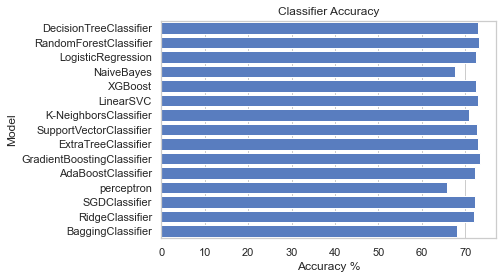

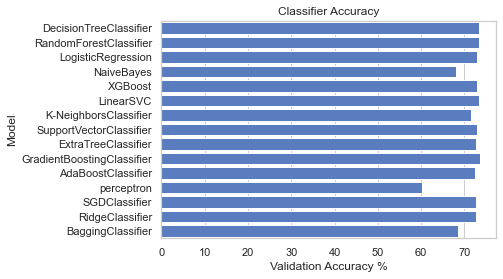

In [327]:
sns.set_color_codes("muted")
sns.barplot(x='Score', y='Model', data=models, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.barplot(x='val accuracy', y='Model', data=models, color="b")

plt.xlabel('Validation Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

## Best Model 

#### Best model with high accuracy is `GradientBoostingClassifier`

In [349]:
print('Accuracy: %.3f' % gradient_acc_score)
# calculate precision
precision = precision_score(y_test, gradient_predicted, labels=[1,0], average='binary')
print('Precision: %.3f' % precision)
# calculate recall
recall = recall_score(y_test, gradient_predicted, labels=[1,0], average='binary')
print('Recall: %.3f' % recall)
# calculate f1-score
f1_score = f1_score(y_test, gradient_predicted, average='binary')
print('F-Measure: %.3f' % f1_score)

Accuracy: 0.735
Precision: 0.752
Recall: 0.692
F-Measure: 0.721
